# Expressions

ironArray has a strong support for expression evaluation.  Things like sums, products, divisions or a pretty complete range of transcendental functions (e.g. `exp`, `sin`, `asin`, `tanh`...).  Fast evaluation of (large) arrays is one of the features that received more love during the development.  Performance comes from a balance between:

1. Use of [Intel MKL](https://software.intel.com/content/www/us/en/develop/tools/oneapi/components/onemkl.html) for accelerating transcendental functions.

2. Use of [Intel SVML](https://software.intel.com/content/www/us/en/develop/documentation/cpp-compiler-developer-guide-and-reference/top/compiler-reference/intrinsics/intrinsics-for-short-vector-math-library-operations/overview-intrinsics-for-short-vector-math-library-svml-functions.html) for computing vector math functions.

3. Use of multi-threading capabilities.

4. Leveraging the 2-level partitioning in ironArray arrays so that most of the computation intensive happens inside private caches (L1, L2), which benefits multi-threading performance.

You can access to the powerful evaluation capabilities in ironArray in different ways, which we are going to succinctly expose in this tutorial.  In order to do that, we are going to make use of the dataset that we created in our reductions tutorial.  Let's go:


In [1]:
import numpy as np
import iarray as ia
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()
meas = {}

In [1] used 0.004 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 100.180 MiB


In [2]:
ia_precip = ia.load("precip-3m.iarr")
ia_precip

<IArray (3, 720, 721, 1440) np.float32>

In [2] used 4.215 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 104.395 MiB


Now, in order to evaluate some expressions on this, let's put the data for each month on a different array:

In [3]:
precip1 = ia_precip[0].copy()
precip2 = ia_precip[1].copy()
precip3 = ia_precip[2].copy()

In [3] used 1656.695 MiB RAM in 21.422s, peaked 0.000 MiB above current, total RAM usage 1761.090 MiB


Note how, even if the data for all the three months takes almost 9 GB uncompressed, ironArray has used just a bit more than 1.7 GB for holding them in RAM.  This is compression at work.

With that, let's compute something easy, like a new array with the mean of these.  For that, we are going to use the internal evaluation engine:

In [4]:
precip_expr = ia.expr_from_string("(p1 + p2 + p3) / 3", {'p1': precip1, 'p2': precip2, 'p3': precip3})

In [4] used 14.172 MiB RAM in 0.029s, peaked 0.000 MiB above current, total RAM usage 1775.262 MiB


Ok, that was fast, but we did not quite evaluate anything yet.  In order to do the actual evaluation, we have to call `.eval()` on the expression:

In [5]:
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

In [5] used 1259.816 MiB RAM in 1.677s, peaked 0.000 MiB above current, total RAM usage 3035.078 MiB


In [6]:
meas["ia_mean"] = mw.measurements

In [6] used 0.012 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 3035.090 MiB


Cool, so we have our first evaluation done.  But let's see how it performs against NumPy, and especially, whether the outcome is correct:

In [7]:
np_precip1 = precip1.data
np_precip2 = precip2.data
np_precip3 = precip3.data

In [7] used 8564.977 MiB RAM in 6.695s, peaked 0.000 MiB above current, total RAM usage 11600.066 MiB


Here we see how the data takes about 9 GB of RAM.  Now, let's do the actual mean:

In [8]:
np_precip_mean = (np_precip1 + np_precip2 + np_precip3) / 3

In [8] used 2852.625 MiB RAM in 2.192s, peaked 0.000 MiB above current, total RAM usage 14452.691 MiB


In [9]:
meas["np_mean"] = mw.measurements

In [9] used 0.039 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 14452.730 MiB


So, ironArray times are quite competitive with NumPy.  How about the correctness of the outcome?.  Let's see:

In [10]:
np.testing.assert_almost_equal(np_precip_mean, precip_mean.data)

In [10] used -7111.055 MiB RAM in 21.516s, peaked 12639.121 MiB above current, total RAM usage 7341.676 MiB


Cool, results are the same. That means that ironArray can run generally faster than NumPy, even if the former uses data in compressed form by default.

Now, let's use expressions with some transcendental functions.  This does not make sense for this case (precipitation data), but we are doing this just as an indication of the efficiency of ironArray:

In [11]:
result = ia.expr_from_string("(tan(p1) * (sin(p1) * sin(p2) + cos(p2)) + sqrt(p3) * 2)",
                             {'p1': precip1, 'p2': precip2, 'p3': precip3}
                             ).eval()
result

<IArray (720, 721, 1440) np.float32>

In [11] used 1923.418 MiB RAM in 2.474s, peaked 0.000 MiB above current, total RAM usage 9265.094 MiB


In [12]:
meas["ia_trans"] = mw.measurements

In [12] used 0.121 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 9265.215 MiB


In this case we see that the overhead of using transcendental functions is pretty low compared with plain arithmetic operations (sum, rest, mult, division...). Let's compare this against NumPy:

In [13]:
p1_ = np_precip1
p2_ = np_precip2
p3_ = np_precip3
np_result = (np.tan(p1_) * (np.sin(p1_) * np.sin(p2_) + np.cos(p2_)) + np.sqrt(p3_) * 2)

In [13] used 7511.871 MiB RAM in 20.759s, peaked 5270.648 MiB above current, total RAM usage 16777.086 MiB


In [14]:
meas["np_trans"] = mw.measurements

In [14] used 0.035 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 16777.121 MiB


Ok, this is really slow, but this is kind of expected, as ironArray comes with support for evaluating transcendental functions via MKL, while NumPy does not.

But do not forget to check for correctness:

In [15]:
np.testing.assert_almost_equal(np_result, result.data)

In [15] used -8166.875 MiB RAM in 22.022s, peaked 13984.164 MiB above current, total RAM usage 8610.246 MiB


Yes, not a noticeable difference, as expected.

## Lazy expressions

So far we have been using strings as the way to build expressions.  However, there is a handier (and perhaps more elegant) way to build expressions via the so-called lazy expressions.  With lazy expressions you just express your computations in terms of `IArray` objects.

For example, the mean of the precipitation would be expressed as:

In [16]:
precip_expr = (precip1 + precip2 + precip3) / 3

In [16] used 4.582 MiB RAM in 0.015s, peaked 0.000 MiB above current, total RAM usage 8614.828 MiB


In [17]:
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

In [17] used 2163.219 MiB RAM in 1.888s, peaked 0.000 MiB above current, total RAM usage 10778.047 MiB


In [18]:
meas["ia_mean_lazy"] = mw.measurements

In [18] used 0.113 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 10778.160 MiB


Lazy expressions are similar to how you use NumPy to evaluate expressions with some differences:

1. You need to be explicit when you want to `.eval()`-uate the expressions.

2. There are no big temporaries involved.  The expression is compiled on the flight and large temporaries are avoided.  This means not only that we require less memory, but more importantly, that expressions evaluate faster (memory access is always expensive).

For evaluating expressions with transcendental functions you need to use ironArray methods:

In [19]:
lazy_expr = ia.tan(precip1) * (ia.sin(precip1) * ia.sin(precip2) + ia.cos(precip2)) + ia.sqrt(precip3) * 2
# Yoy can also use the next idiom, which is not as close to NumPy, but a hair more concise
#lazy_expr = precip1.tan() * (precip1.sin() * precip2.sin() + precip2.cos()) + precip3.sqrt() * 2

In [19] used 0.109 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 10778.270 MiB


In [20]:
lazy_result = lazy_expr.eval()
lazy_result


<IArray (720, 721, 1440) np.float32>

In [20] used 1066.453 MiB RAM in 2.312s, peaked 0.000 MiB above current, total RAM usage 11844.723 MiB


In [21]:
meas["ia_trans_lazy"] = mw.measurements

In [21] used 0.008 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 11844.730 MiB


Note how execution times and memory usage are very similar to the string expressions evaluator.

As you can see, lazy expressions allow for a more Pythonic way to integrate ironArray operands in expressions, just like NumPy (only more memory efficient and faster).  In general, you can use the method you like the most, although evaluation of string expressions tends to be a hair faster, especially when using small arrays.

As always, let's check that the result is correct:

In [22]:
np.testing.assert_almost_equal(np_result, lazy_result.data)

In [22] used -3893.945 MiB RAM in 16.932s, peaked 13633.137 MiB above current, total RAM usage 7950.785 MiB


## Resource consumption

As a summary, let's do a plot on the speed for the different kind of computations:

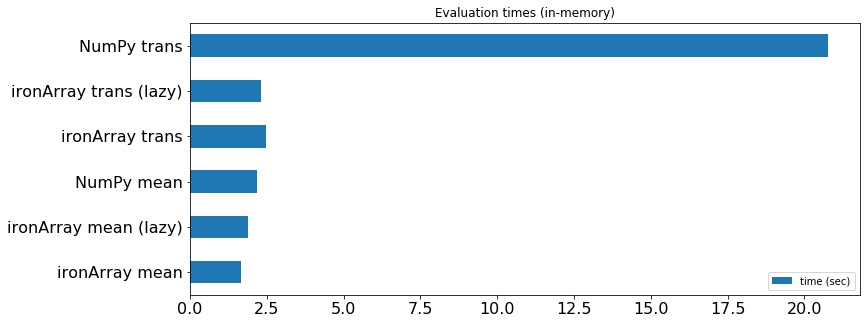

In [23] used 75.617 MiB RAM in 0.762s, peaked 0.000 MiB above current, total RAM usage 8026.402 MiB


In [23]:
%matplotlib inline
import pandas as pd

labels = ["ironArray mean",
          "ironArray mean (lazy)",
          "NumPy mean",
          "ironArray trans",
          "ironArray trans (lazy)",
          "NumPy trans"]
df = pd.DataFrame({'time (sec)': [
    meas["ia_mean"].time_delta,
    meas["ia_mean_lazy"].time_delta,
    meas["np_mean"].time_delta,
    meas["ia_trans"].time_delta,
    meas["ia_trans_lazy"].time_delta,
    meas["np_trans"].time_delta]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Evaluation times (in-memory)")

and the memory used for every kind of computations:

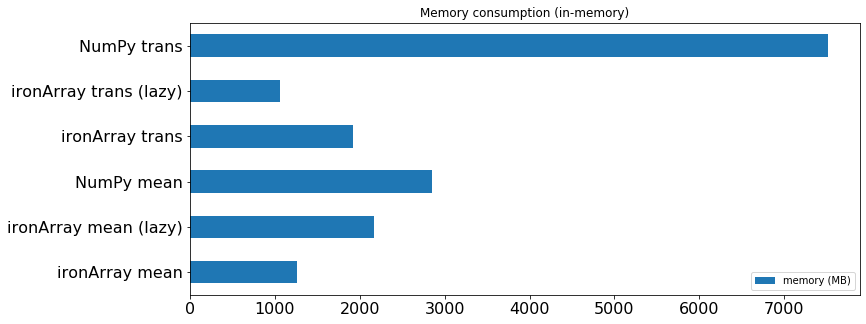

In [24] used 0.562 MiB RAM in 0.135s, peaked 0.000 MiB above current, total RAM usage 8026.965 MiB


In [24]:
labels = [
    "ironArray mean",
    "ironArray mean (lazy)",
    "NumPy mean",
    "ironArray trans",
    "ironArray trans (lazy)",
    "NumPy trans"]
df = pd.DataFrame({'memory (MB)': [
    meas["ia_mean"].memory_delta,
    meas["ia_mean_lazy"].memory_delta,
    meas["np_mean"].memory_delta,
    meas["ia_trans"].memory_delta,
    meas["ia_trans_lazy"].memory_delta,
    meas["np_trans"].memory_delta]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Memory consumption (in-memory)")

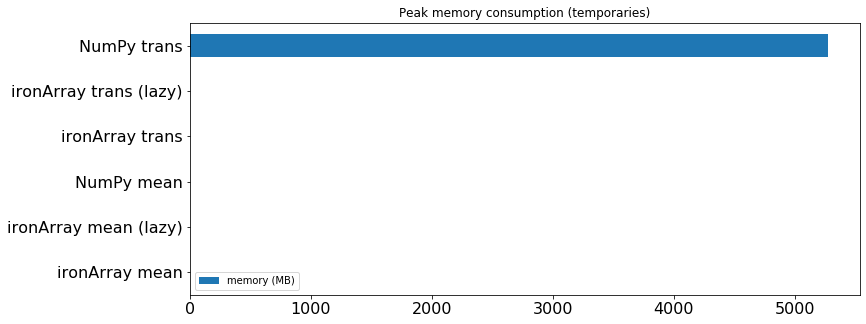

In [25] used 0.742 MiB RAM in 0.117s, peaked 0.000 MiB above current, total RAM usage 8027.707 MiB


In [25]:
labels = [
    "ironArray mean",
    "ironArray mean (lazy)",
    "NumPy mean",
    "ironArray trans",
    "ironArray trans (lazy)",
    "NumPy trans"]
df = pd.DataFrame({'memory (MB)': [
    meas["ia_mean"].memory_peak,
    meas["ia_mean_lazy"].memory_peak,
    meas["np_mean"].memory_peak,
    meas["ia_trans"].memory_peak,
    meas["ia_trans_lazy"].memory_peak,
    meas["np_trans"].memory_peak]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Peak memory consumption (temporaries)")

## Out-of-Core Expressions

So far we have been evaluating expressions on top of arrays that are in-memory.  One of the nice features of ironArray is that it can seamslessly handle arrays that are on-disk too; this capability is also known as out-of-core operation.

So as to show this, we are going to use our original on-disk array and will create an on-disk outcome where we will put the result of our operations.  Let's start:

In [26]:
precip1 = ia_precip[0]
precip2 = ia_precip[1]
precip3 = ia_precip[2]

In [26] used 0.039 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 8027.746 MiB


In this case, we are just getting views of the larger array that is on-disk.  Remember that views do not create new containers, so this is why the above operation is fast.  Now, let's build the expression for the mean values:

In [27]:
precip_mean = (precip1 + precip2 + precip3) / 3

In [27] used 0.074 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 8027.820 MiB


and now let's evaluate and making sure that the result is created on-disk:

In [28]:
with ia.config(storage=ia.Storage(filename="mean-3m.iarr")) as cfg:
    precip_mean_disk = precip_mean.eval(cfg=cfg)
precip_mean

In [28] used 63.043 MiB RAM in 22.863s, peaked 0.000 MiB above current, total RAM usage 8090.863 MiB


In [29]:
meas["ia_mean_disk"] = mw.measurements

In [29] used -0.023 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 8090.840 MiB


We see that evaluation from disk takes quite more than operating in memory, but this is kind of expected.  What we are more interested here is the amount of RAM needed to perform the evaluation has been on the order of 100 MB, whereas the output array is quite larger than this:

In [30]:
%ls -lh mean-3m.iarr

-rw-r--r--  1 faltet  staff   1.2G Dec 15 14:46 mean-3m.iarr
In [30] used 0.039 MiB RAM in 0.618s, peaked 0.000 MiB above current, total RAM usage 8090.879 MiB


So, with a result size of more than 1 GB, it is more than 10x than the memory used.  In addition, the 100 MB in memory is probably being taken by temporaries that Python takes some time to release back, so in the long run this figure should be considered more a temporary peak that will be eventually reclaimed by the interpreter for other uses.  But still, it is important to realize that this memory is needed.

For the sake of comparison, let's see how similar array libraries perform at this.  Zarr is the most obvious container because it supports the same Blosc compressor, so this will allow for a apple to apple comparison.  Let's create a Zarr container out of our current one:

In [31]:
import zarr
from functools import reduce
ia_defs = ia.Config()

In [31] used 0.566 MiB RAM in 0.046s, peaked 0.000 MiB above current, total RAM usage 8091.445 MiB


In [32]:
blocksize = reduce(lambda x, y: x * y, ia_precip.blockshape) * np.dtype(np.float32).itemsize
zarr_precip = zarr.open(
    "precip-3m.zarr", "w", shape=ia_precip.shape, chunks=ia_precip.chunkshape, dtype=ia_precip.dtype,
    compressor=zarr.Blosc(clevel=ia_defs.clevel, cname="lz4", blocksize=blocksize),
)

In [32] used 0.047 MiB RAM in 0.027s, peaked 0.000 MiB above current, total RAM usage 8091.492 MiB


and do the copy:

In [33]:
ia_precip.copyto(zarr_precip)

In [33] used 231.723 MiB RAM in 188.866s, peaked 1049.109 MiB above current, total RAM usage 8323.215 MiB


and now do the mean by using Dask:

In [34]:
import dask
import dask.array as da

In [34] used 4.664 MiB RAM in 0.180s, peaked 0.000 MiB above current, total RAM usage 8327.879 MiB


In [35]:
precip_mean_disk = ia.load("mean-3m.iarr")
blocksize = reduce(lambda x, y: x * y, precip_mean_disk.blockshape) * np.dtype(np.float32).itemsize
shape = precip_mean_disk.shape
chunks = precip_mean_disk.chunkshape
dtype = np.float32
clevel = ia_defs.clevel

In [35] used 0.039 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 8327.918 MiB


In [42]:
with dask.config.set(scheduler="threads"):
    precip = zarr.open("precip-3m.zarr")
    d = da.from_zarr(precip)
    precip1 = d[0]
    precip2 = d[1]
    precip3 = d[2]
    res = (precip1 + precip2 + precip3) / 3
    zarr_precip_mean_disk = zarr.open(
        "mean-3m.zarr",
        "w",
        shape=shape,
        chunks=chunks,
        dtype=dtype,
        compressor=zarr.Blosc(clevel=clevel, cname="lz4", blocksize=blocksize),
    )
    da.to_zarr(res, zarr_precip_mean_disk)

In [42] used -346.070 MiB RAM in 65.711s, peaked 12377.469 MiB above current, total RAM usage 2344.012 MiB


In [43]:
meas["dask_mean_disk"] = mw.measurements

In [43] used 12.285 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 2356.297 MiB


In this case we see that Dask+Zarr took about 3x more time than ironArray in performing the operations.  But perhaps more importantly, Dask+Zarr took a considerable about of peak RAM to complete the operation (more than 10 GB), which is much more than ironArray (around 100 MB).

Here it is a comparison of the times on a plot:

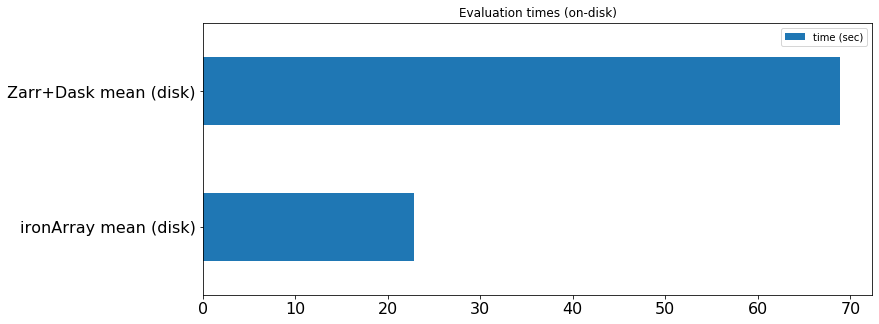

In [38] used 9.434 MiB RAM in 0.130s, peaked 0.000 MiB above current, total RAM usage 4294.113 MiB


In [38]:
%matplotlib inline
import pandas as pd

labels = ["ironArray mean (disk)", "Zarr+Dask mean (disk)"]
df = pd.DataFrame({'time (sec)': [
    meas["ia_mean_disk"].time_delta, meas["dask_mean_disk"].time_delta]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Evaluation times (on-disk)")

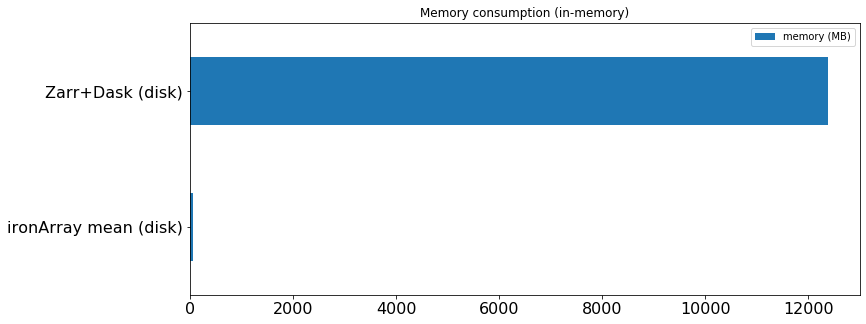

In [44] used 0.316 MiB RAM in 0.117s, peaked 0.000 MiB above current, total RAM usage 2356.613 MiB


In [44]:
labels = ["ironArray mean (disk)", "Zarr+Dask (disk)"]
df = pd.DataFrame({'memory (MB)': [
    meas["ia_mean_disk"].memory_delta, meas["dask_mean_disk"].memory_peak]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Memory consumption (in-memory)")


This is a general feature of ironArray: perform evaluations while keeping memory usage low.  This allows to compute operations on arbitrarily large arrays (as long as disk storage allows) without worrying about RAM capacities.

## Optimization Tips

Even if ironArray has been quite competitive in terms of speed and memory consumption, so far the computations have been done using just the default values.  Let's see how we can accelerate things here.

First, let's start by using larger chunks and see.  First, let's see which are our current sizes:

In [40]:
print(precip1.chunkshape)
print(precip1.blockshape)

AttributeError: 'Array' object has no attribute 'chunkshape'

In [40] used 2.578 MiB RAM in 0.231s, peaked 0.000 MiB above current, total RAM usage 4297.137 MiB


Let's duplicate

TODO: Introduce UDFs, and an 'Optimization tips' section...

TODO: Add a comparison with xarray or dask, for out-of-core reductions

In [ ]:
mw.stop_watching_memory()